# Multi-Layer Perceptron Using LDA

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load LDA-transformed features and labels
X_lda = np.load("X_lda.npy")  # Shape: (2511, reduced_dim)
y = np.load("y_labels.npy")   # Shape: (2511,)

# Split Data (70% Train, 20% Test, 10% Validation)
X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)


In [2]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# Model setup
input_dim = X_train.shape[1]  # LDA feature dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20

# Store losses and accuracies
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct * 100 / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct * 100 / val_total)

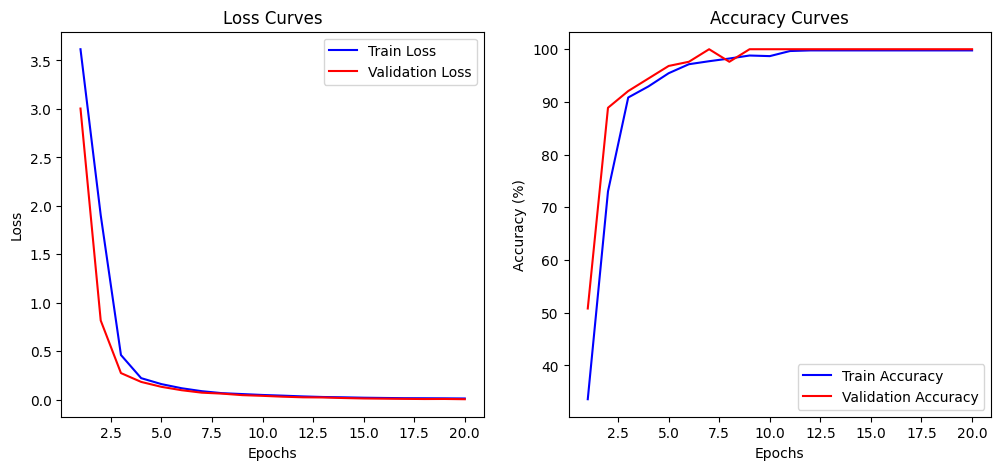

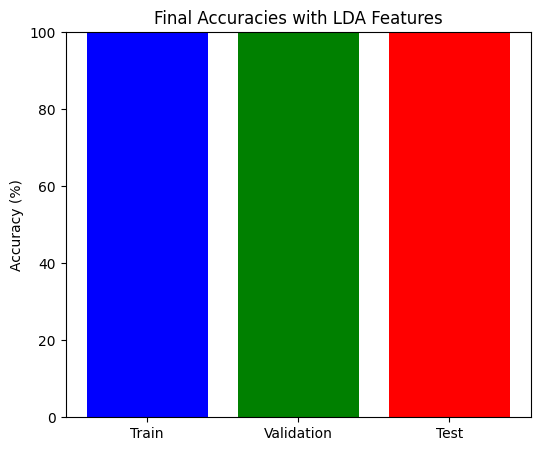

Final Accuracies using LDA:
Train Accuracy: 99.77%
Validation Accuracy: 100.00%
Test Accuracy: 100.00%


In [5]:
# Evaluate on Test Set
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == batch_y).sum().item()
        test_total += batch_y.size(0)
test_acc = test_correct * 100 / test_total

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

# Bar Chart for Final Accuracies
labels = ["Train", "Validation", "Test"]
final_accuracies = [train_accs[-1], val_accs[-1], test_acc]

plt.figure(figsize=(6, 5))
plt.bar(labels, final_accuracies, color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Final Accuracies with LDA Features")
plt.show()

# Print final results
train_acc_final = train_accs[-1]
val_acc_final = val_accs[-1]
print("Final Accuracies using LDA:")
print(f"Train Accuracy: {train_acc_final:.2f}%")
print(f"Validation Accuracy: {val_acc_final:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")